# Linear Optimal Control and MPC using [the] Linear Inverted Pendulum Model

In [1]:
%matplotlib inline
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Define states and controls
We select as states the position $\mathbf{r}\in\mathbb{R}^2$ and velocity $\dot{\mathbf{r}}\in\mathbb{R}^2$ of the Center of Mass (CoM) along the $XY$ directions.

We collect the states into a single state vector $\mathbf{x}$:

$\mathbf{x} = \begin{bmatrix}\mathbf{r} \\ \dot{\mathbf{r}} \end{bmatrix} \in \mathbb{R}^4$

In [2]:
# States
nr = 2 # CoM position size
nrdot = 2 # CoM velocity size

nx = nr + nrdot # State dimension

We use as control the Zero Moment Point (ZMP):

$\mathbf{u} = \mathbf{z} \in \mathbb{R}^2$

In [3]:
# Controls
nz = 2 # ZMP position

nu = nz # Control dimension

## Optimal Control Problem Parameters
The parameters of the Optimal Control (OC) problem are:

- the number of nodes $ns$
- the final time $tf$

They are used to compute the time interval $dt = \frac{tf}{ns}$.

IMPORTANT: We consider $ns+1$ states and $ns$ controls. We start from a state $\mathbf{x}_k$ and apply the control $\mathbf{u}_k$ to end up in state $\mathbf{x}_{k+1}$, $\forall k \in \{0, ..., ns-1 \}$. There is no control applied at the final node.

In [4]:
ns = 40 # Number of nodes
tf = 3. # Total time in seconds 
dt = tf/ns

## Linear Inverted Pendulum Model Params
The equations of motion for the Linear Inverted Pendulum Model (LIPM) are:

$\ddot{\mathbf{r}} = \omega^2\left(\mathbf{r} - \mathbf{z}\right)$

with $\omega = \sqrt{\frac{9.81}{h}}$ and $h:$ the height of the CoM considered constant.

In [5]:
h = 0.83 # CoM height (constant)
w = np.sqrt(9.81/h)

## Define LIPM Dynamics
The dynamics of the system are defined as a double integrator:

$\dot{\mathbf{x}} = \begin{bmatrix} \dot{\mathbf{r}} \\ \ddot{\mathbf{r}} \end{bmatrix} = \begin{bmatrix} \dot{\mathbf{r}} \\ \omega^2 \left(\mathbf{r} - \mathbf{z} \right) \end{bmatrix} \in \mathbb{R}^4$, 

which is linear in the states and controls:

$\dot{\mathbf{x}} = \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{u} = \begin{bmatrix} \mathbf{0} & \mathbf{I} \\ \omega^2 \mathbf{I} & \mathbf{0}\end{bmatrix}\begin{bmatrix}\mathbf{r} \\ \dot{\mathbf{r}} \end{bmatrix} + \begin{bmatrix} \mathbf{0} \\ -\omega^2 \mathbf{I} \end{bmatrix}\mathbf{z}$

In [6]:
def dynamics(w):
    A = np.zeros((nx, nx))
    A[0:2, 2:4] = np.eye(2)
    A[2:4, 0:2] = w**2 * np.eye(2)

    B = np.zeros((nx, nu))
    B[2:4, 0:2] = -w**2 * np.eye(2)
    return A, B

## Cost Function
We consider a cost function made up of a sum of L2-norm terms. For the first $ns$ nodes, we wish to minimize the CoM velocity and the control action (ZMP). In the final node, we wish to minimize the CoM velocity.

This cost function can be written as a Quadratic Program (QP):

$F =  \frac{1}{2} \sum\limits_{k=0}^{ns-1}\left[Q\dot{\mathbf{r}}_k^T\dot{\mathbf{r}}_k + R\left( \mathbf{z}_k - \mathbf{z}_{r,k} \right)^T\left( \mathbf{z}_k - \mathbf{z}_{r,k} \right)\right] + Q_{fin}\dot{\mathbf{r}}_{ns}^T\dot{\mathbf{r}}_{ns} = $

$=\frac{1}{2}\begin{bmatrix}\mathbf{x}^T & \mathbf{u}^T \end{bmatrix}^T \mathbf{H}\begin{bmatrix}\mathbf{x} \\ \mathbf{u} \end{bmatrix} + \mathbf{g}^T\begin{bmatrix}\mathbf{x} \\ \mathbf{u} \end{bmatrix}$

The Hessian $\mathbf{H}$ and the gradient $\mathbf{g}$ have the following dimensions: 

$\mathbf{H} \in \mathbb{R}^{ns(nx + nu) + nx \times ns(nx + nu) + nx}$

$\mathbf{g} \in \mathbb{R}^{ns(nx + nu) + nx}$

In particular, the Hessian is block diagonal with the single block:

$\mathbf{H}_k = \begin{bmatrix}\mathbf{r}_k^T & \dot{\mathbf{r}}_k^T & \mathbf{u}_k^T \end{bmatrix} 
\begin{bmatrix}
\mathbf{0} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & Q\mathbf{I} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & R\mathbf{I}
\end{bmatrix}
\begin{bmatrix}\mathbf{r}_k \\ \dot{\mathbf{r}}_k \\ \mathbf{u}_k \end{bmatrix}$,

the final row:

$\mathbf{H}_{ns} = \begin{bmatrix}\mathbf{r}_{ns}^T & \dot{\mathbf{r}}_{ns}^T \end{bmatrix} 
\begin{bmatrix}
\mathbf{0} & \mathbf{0} \\
\mathbf{0} & Q_{fin}\mathbf{I}
\end{bmatrix}
\begin{bmatrix}\mathbf{r}_{ns} \\ \dot{\mathbf{r}}_{ns} \end{bmatrix}$.

While the gradient:
$\mathbf{g}_k = \begin{bmatrix}\mathbf{0}^T  & \mathbf{0}^T & -R\mathbf{z}_{ref}^T  \end{bmatrix}\begin{bmatrix}\mathbf{r}_k \\ \dot{\mathbf{r}}_k \\ \mathbf{u}_k \end{bmatrix}$.

Notice: the reference enters in the gradient only.

In [7]:
# Cost Function Params
Q = 1e-3
Qfin = 1e6
R = 1e1

In [8]:
def running_cost_hessian(Q, R):
    """
    Hessian running cost for a single stage
    """
    H = np.zeros((nx + nu, nx + nu))
    H[2:4, 2:4] = Q * np.eye(2)
    H[4:6, 4:6] = R * np.eye(2)
    return H

In [9]:
def running_cost_gradient(R, zref):
    """
    Gradient running cost for single stage
    """
    g = np.zeros((nx + nu, 1))
    g[4:6,0] = -R * zref
    return g

In [10]:
def final_cost_hessian(Qfin):
    """
    Hessian final cost
    """
    H = np.zeros((nx, nx))
    H[2:4, 2:4] = Qfin * np.eye(2)
    return H

In [11]:
# Build the QP matrices
H = np.zeros((ns * (nx + nu) + nx, ns * (nx + nu) + nx))
for i in range(ns):
    H[i * (nx + nu):(i + 1) * (nx + nu), i * (nx + nu):(i + 1) * (nx + nu)] = running_cost_hessian(Q, R)
H[-nx:, -nx:] = final_cost_hessian(Qfin)

In [12]:
grad = np.zeros((ns * (nx + nu) + nx, 1))
for i in range(ns):
    grad[i * (nx + nu):(i + 1) * (nx + nu)] = running_cost_gradient(R, np.zeros((2,1)).flatten())

## Constraints

### Euler Integration: 
Let's impose the system dynamics (double integrator). We'll use Euler integration for the discretization:

$\mathbf{x}_{k+1} = \mathbf{x}_{k} + \dot{\mathbf{x}}_{k}dt = \mathbf{x}_{k} + dt\left(\mathbf{Ax}_k + \mathbf{Bu}_k \right) = \left( \mathbf{I} + dt\mathbf{A}\right)\mathbf{x}_k + dt\mathbf{Bu}_k$

The linear constraint can be written:

$\left( \mathbf{I} + dt\mathbf{A}\right)\mathbf{x}_k + dt\mathbf{Bu}_k - \mathbf{x}_{k+1} = \mathbf{0}$

For a single stage (node) in matrix form:

$\begin{bmatrix}dt\mathbf{A}+\mathbf{I} & dt\mathbf{B} & -\mathbf{I} \end{bmatrix}\begin{bmatrix}\mathbf{x}_k \\ \mathbf{u}_k \\ \mathbf{x}_{k+1}\end{bmatrix}$,

This constraint connects $\mathbf{x}_k$ with $\mathbf{x}_{k+1}$ through the applied control $\mathbf{u}_k$.

The final constraint has the form:

$\mathbf{E}\begin{bmatrix}\mathbf{x}_0 \\ \mathbf{u}_0 \\ \dots \\ \mathbf{x}_{ns-1} \\ \mathbf{u}_{ns-1} \\ \mathbf{x}_{ns}\end{bmatrix} = \mathbf{0}$

In [13]:
def Euler(A, B, dt):
    """
    Euler integration for a single stage (node)
    """
    E = np.zeros((nx, 2 * nx + nu))
    E[:, 0:nx] = np.eye(nx) + dt * A
    E[:, nx:nx + nu] = dt * B
    E[:, nx + nu:] = -np.eye(nx)
    return E

In [14]:
# Integrate over the full horizon
E = np.zeros((ns * nx, ns * (nx + nu) + nx))
A, B = dynamics(w)
for i in range(ns):
    E[i * nx:(i + 1) * nx, i * (nx + nu):(i + 1) * (nx + nu) + nx] = Euler(A, B, dt)

e = np.zeros((ns * nx, 1))

### Initial state
We want to impose the value of the initial state:

$\mathbf{x}_0 = \mathbf{x}_m$,

which can be written in matrix form:

$\begin{bmatrix}\mathbf{I} & \mathbf{0} & \dots & \mathbf{0} \end{bmatrix} \begin{bmatrix}\mathbf{x}_0 \\ \mathbf{x}_1 \\ \vdots \\ \mathbf{x}_{ns+1}\end{bmatrix} = \mathbf{x}_m$

In [15]:
# Initial state constraint
x0 = np.zeros((nx,1))
e = np.concatenate([e, x0])
init_state_constraint = np.zeros((nx, ns * (nx + nu) + nx))
init_state_constraint[:, :nx] = np.eye(nx)
E = np.vstack((E, init_state_constraint))

## ZMP Reference
The OC permits us to track a reference for the ZMP. We design a reference for the $Y$ plane, i.e., stepping in place. The robot steps first to the left, then to the right, and finally it goes back with both feet on the ground (ZMP in the center). References are generated for all the nodes in the horizon.

In [16]:
# We consider the position of the left and right foot on the y to be -0.1 and 0.1 respectively.
def zmp_ref(ns):
    zref = np.zeros((2, ns))
    for i in range(ns):
        zref[:, i] = np.zeros((2, 1)).flatten()
        if i >= 10 and i < 20:
            zref[:, i] = np.array([0.0, 0.1])
        elif i >= 20 and i < 30:
            zref[:, i] = np.array([0.0, -0.1])
        elif i >= 30:
            zref[:, i] = np.array([0.0, 0.])
    return zref

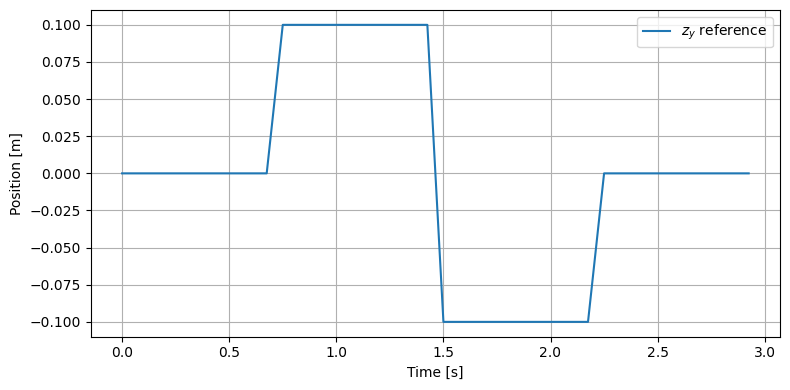

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(ns) * dt, zmp_ref(ns)[1,:], label='$z_y$ reference')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Solve the QP
We end up with an equality-constrained QP:

$\min_{\mathbf{x}, \mathbf{u}} \frac{1}{2}\begin{bmatrix}\mathbf{x}^T & \mathbf{u}^T \end{bmatrix}^T \mathbf{H}\begin{bmatrix}\mathbf{x} \\ \mathbf{u} \end{bmatrix} + \mathbf{g}^T\begin{bmatrix}\mathbf{x} \\ \mathbf{u} \end{bmatrix}$

$s.t. \mathbf{E}\begin{bmatrix}\mathbf{x} \\ \mathbf{u} \end{bmatrix} = \mathbf{e}$

that can be solved building the KKT linear system:

$\begin{bmatrix}\mathbf{H} & \mathbf{E}^T \\ \mathbf{E} & \mathbf{0}\end{bmatrix} \begin{bmatrix}\mathbf{x} \\ \mathbf{u} \\ \boldsymbol{\lambda} \end{bmatrix} = \begin{bmatrix}-\mathbf{g} \\ \mathbf{e} \end{bmatrix}$

In [19]:
def calcKKT(H, E):
    # Build the KKT system (this step can be performed only once since the system does not change!)
    KKT = np.zeros((H.shape[0] + E.shape[0], H.shape[0] + E.shape[0]))
    KKT[:H.shape[0], :H.shape[0]] = H
    KKT[:H.shape[0], H.shape[0]:] = E.T
    KKT[H.shape[0]:, :H.shape[0]] = E
    return KKT

def solveQP(H, grad, E, e):
    KKT = calcKKT(H, E)
    rhs = np.concatenate([-grad, e]) # This can change during execution!

    # Solve the KKT system
    return np.linalg.solve(KKT, rhs)

## Solve the Trajectory Optimization Problem
We first solve the Trajectory Optimization (TO) problem, which can be useful to check the correctness of the code.
As a TO problem, we assign the ZMP references and compute the solution.
Notice that due to linearity the QP is solved in a single step.

In [21]:
# Assing reference for ZMP
for j in range(ns):
         grad[j * (nx + nu):(j + 1) * (nx + nu)] = running_cost_gradient(R, zmp_ref(ns)[:, j].flatten())

In [22]:
# Solve the QP
y = solveQP(H, grad, E, e)

In [23]:
# Extract state trajectories
x = np.zeros((ns + 1) * nx)
for i in range(ns):
    x[i * nx:(i + 1) * nx] = y[i * (nx + nu):i * (nx + nu) + nx].flatten()
# Fill last state
x[ns * nx:(ns + 1) * nx] = y[ns * (nx + nu):ns * (nx + nu) + nx].flatten()

# Extract control trajectories
u = np.zeros((nu, ns))
for i in range(ns):
    # The control vector u is after the state x in y:
    start_idx = i * (nx + nu) + nx
    end_idx = start_idx + nu
    u[:, i] = y[start_idx:end_idx].flatten()

In [24]:
# Extract r and rdot
r = np.zeros((2, ns + 1))
rdot = np.zeros((2, ns + 1))
for i in range(ns + 1):
    r[:, i] = x[i * nx:i * nx + 2].flatten()
    rdot[:, i] = x[i * nx + 2:i * nx + 4].flatten()

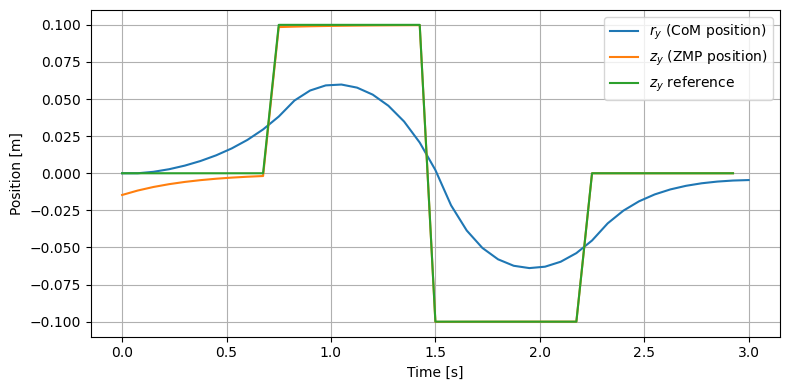

In [26]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(np.arange(ns + 1) * dt, r[1, :], label='$r_y$ (CoM position)')
plt.plot(np.arange(ns) * dt, u[1,:], label='$z_y$ (ZMP position)')
plt.plot(np.arange(ns) * dt, zmp_ref(ns)[1,:], label='$z_y$ reference')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Notice that to move the CoM up (left) the ZMP moves instantaneously down (right) and consecutively track closely the reference.

## Model Predictive Control
To solve the Model Predictive Control (MPC) problem, we solve the QP in a loop. At each iteration, we assign a new initial state and reference to the problem.

In this example, we compute the next state simply by applying the control to the actual state (this corresponds to using the second state $\mathbf{x}_1$ computed by the QP).

For assigning the reference, we consider the reference starting from the end and moving toward the initial state (receding horizon).

In [27]:
# Zero all references
for i in range(ns):
    grad[i * (nx + nu):(i + 1) * (nx + nu)] = running_cost_gradient(R, np.zeros((2,1)).flatten())

In [28]:
# Simulation parameters
T = 4 * ns # Simulation time

In [29]:
x = np.zeros((nx, ns)) # Collect states
z = np.zeros((nu, ns)) # Collect controls

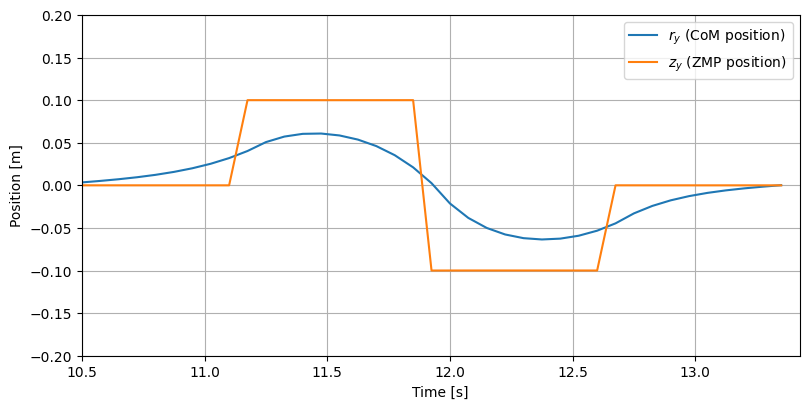

In [31]:
x0 = np.zeros((nx, 1))
zmp_r = zmp_ref(ns)  # Future ZMP references
zmp_d = np.zeros(zmp_r.shape)

# --- Prepare plot ---
plt.ion()
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot(np.arange(ns) * dt, zmp_d[1, :], 'b-', label='$z_d$ (zmp desired)')
ax.set_xlim(0, ns * dt)
ax.set_xlabel('Time [s]')
ax.set_ylabel('ZMP [m]')
ax.set_title('ZMP Desired Over Time')
ax.legend()
fig.tight_layout()

scroll = 0
# --- Main Loop ---
for i in range(T):
    x[:, i%ns] = x0.flatten()
    
    # We set the initial value constraint to the new initial value (in the real robot this is measured!)
    e[-nx:] = x0

    # Shift reference to the left
    for j in range(1, ns):
        zmp_d[:, j-1] = zmp_d[:, j]
    # Copy the new reference at the end of the horizon
    zmp_d[:, ns-1] = zmp_r[:, i % ns]
    
    # Compute gradient (assign reference to the problem)
    for j in range(ns):
        grad[j * (nx + nu):(j + 1) * (nx + nu)] = running_cost_gradient(R, zmp_d[:, j])

    # Solve the QP
    y = solveQP(H, grad, E, e)

    # Retrieve computed control
    u0 = y[nx:nx + nu]

    # Compute new state integrating
    x1 = x0 + dt * (A @ x0 + B @ u0)

    # New state is new initial state
    x0 = x1

    u[:, i%ns] = u0.flatten()

    # --- Update Plot ---
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    if i >= ns/2:
        scroll = scroll + 1
    
    plt.plot(np.arange(scroll, i%ns+scroll)*dt, x[1, 0:i%ns], label='$r_y$ (CoM position)')
    plt.plot(np.arange(scroll, i%ns+scroll)*dt, u[1, 0:i%ns], label='$z_y$ (ZMP position)')
    plt.ylim(-0.2, 0.2)
    plt.xlim(0 + scroll*dt, (i%ns+scroll)*dt)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.show()

# Keep the final plot open
plt.ioff()
plt.show()


## Some Optimization
It is worth noting that, during the control loop, the only parts that change are the gradient and constraint values (Time-invariant linear system). This means that we do not need to compute the Hessian, the constraint matrix, and consequently the KKT matrix and its inversion at every control loop.

In [32]:
KKT = calcKKT(H, E)
iKKT = np.linalg.pinv(KKT)

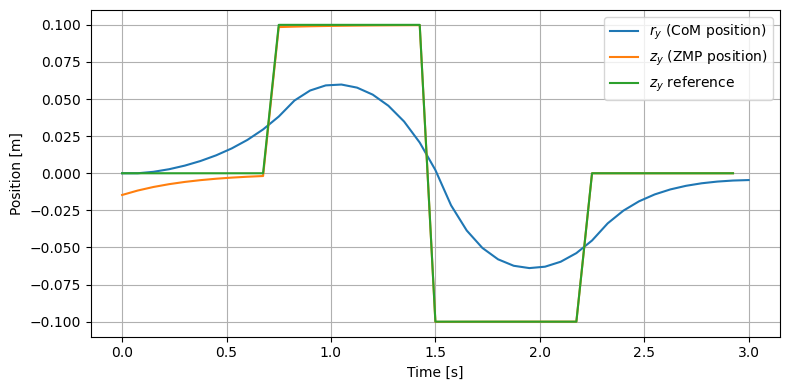

In [33]:
## Trajectory Optimization

# Assign reference for zmp
for j in range(ns):
         grad[j * (nx + nu):(j + 1) * (nx + nu)] = running_cost_gradient(R, zmp_ref(ns)[:, j].flatten())

# Initial state
e[-nx:] = np.zeros((nx,1))

rhs = np.concatenate([-grad, e])

y = iKKT@rhs

# Extract state trajectories
x = np.zeros((ns + 1) * nx)
for i in range(ns):
    x[i * nx:(i + 1) * nx] = y[i * (nx + nu):i * (nx + nu) + nx].flatten()
# Fill last state
x[ns * nx:(ns + 1) * nx] = y[ns * (nx + nu):ns * (nx + nu) + nx].flatten()

# Extract control trajectories
u = np.zeros((nu, ns))
for i in range(ns):
    # The control vector u is after the state x in y:
    start_idx = i * (nx + nu) + nx
    end_idx = start_idx + nu
    u[:, i] = y[start_idx:end_idx].flatten()

# Extract r and rdot
r = np.zeros((2, ns + 1))
rdot = np.zeros((2, ns + 1))
for i in range(ns + 1):
    r[:, i] = x[i * nx:i * nx + 2].flatten()
    rdot[:, i] = x[i * nx + 2:i * nx + 4].flatten()

# Plot
plt.figure(figsize=(8, 4))
plt.plot(np.arange(ns + 1) * dt, r[1, :], label='$r_y$ (CoM position)')
plt.plot(np.arange(ns) * dt, u[1,:], label='$z_y$ (ZMP position)')
plt.plot(np.arange(ns) * dt, zmp_ref(ns)[1,:], label='$z_y$ reference')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

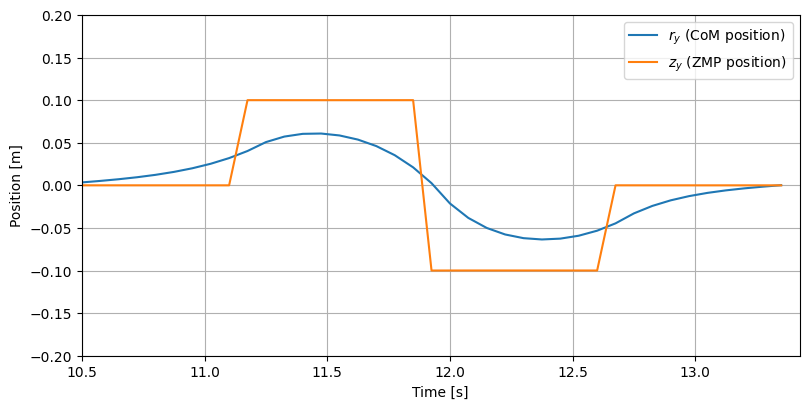

In [34]:
## MPC

# Zero all references
for i in range(ns):
    grad[i * (nx + nu):(i + 1) * (nx + nu)] = running_cost_gradient(R, np.zeros((2,1)).flatten())

x = np.zeros((nx, ns)) # Collect states
z = np.zeros((nu, ns)) # Collect controls

x0 = np.zeros((nx, 1))
zmp_r = zmp_ref(ns)  # Future ZMP references
zmp_d = np.zeros(zmp_r.shape)

# --- Prepare Plot ---
plt.ion()
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot(np.arange(ns) * dt, zmp_d[1, :], 'b-', label='$z_d$ (zmp desired)')
ax.set_xlim(0, ns * dt)
ax.set_xlabel('Time [s]')
ax.set_ylabel('ZMP [m]')
ax.set_title('ZMP Desired Over Time')
ax.legend()
fig.tight_layout()

scroll = 0
# --- Main Loop ---
for i in range(T):
    x[:, i%ns] = x0.flatten()

    e[-nx:] = x0

    # Shift reference
    for j in range(1, ns):
        zmp_d[:, j-1] = zmp_d[:, j]
    zmp_d[:, ns-1] = zmp_r[:, i % ns]
    
    # Compute gradient
    for j in range(ns):
        grad[j * (nx + nu):(j + 1) * (nx + nu)] = running_cost_gradient(R, zmp_d[:, j])

    # Solve the QP
    rhs = np.concatenate([-grad, e])
    y = iKKT@rhs

    u0 = y[nx:nx + nu]
    x1 = x0 + dt * (A @ x0 + B @ u0)
    x0 = x1

    u[:, i%ns] = u0.flatten()

    # --- Update Plot ---
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    if i >= ns/2:
        scroll = scroll + 1
    
    plt.plot(np.arange(scroll, i%ns+scroll)*dt, x[1, 0:i%ns], label='$r_y$ (CoM position)')
    plt.plot(np.arange(scroll, i%ns+scroll)*dt, u[1, 0:i%ns], label='$z_y$ (ZMP position)')
    plt.ylim(-0.2, 0.2)
    plt.xlim(0 + scroll*dt, (i%ns+scroll)*dt)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.show()

plt.ioff()
plt.show()
